In [1]:
import os
import pandas as pd
import re
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import spacy  # For preprocessing
import en_core_web_lg

In [2]:
nlp = en_core_web_lg.load()

In [3]:
from gensim.models.phrases import Phrases, Phraser
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [4]:
def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

In [5]:
file=open('text_polsat.txt','r')
content =file.read()
content_list = content.split(",")
file.close()

df=pd.DataFrame(content_list)

brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df[0])

t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()

INFO - 15:45:29: NumExpr defaulting to 8 threads.


Time to clean up everything: 7.65 mins


In [6]:
sent = [row.split() for row in df_clean['clean']]

In [7]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 15:45:29: collecting all words and their counts
INFO - 15:45:29: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 15:45:30: PROGRESS: at sentence #10000, processed 110202 words and 75097 word types
INFO - 15:45:31: PROGRESS: at sentence #20000, processed 223489 words and 133270 word types
INFO - 15:45:32: PROGRESS: at sentence #30000, processed 335856 words and 184178 word types
INFO - 15:45:32: collected 196436 word types from a corpus of 364667 words (unigram + bigrams) and 32481 sentences
INFO - 15:45:32: using 196436 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [8]:
bigram = Phraser(phrases)

INFO - 15:45:32: source_vocab length 196436
INFO - 15:45:40: Phraser built with 276 phrasegrams


In [9]:
sentences = bigram[sent]

In [10]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

15386

In [11]:
sorted(word_freq, key=word_freq.get, reverse=True)[:20]

['quot',
 'say',
 's',
 'poland',
 'people',
 'president',
 'year',
 'government',
 'polish',
 'state',
 'add',
 'video',
 'protest',
 'time',
 'prime_minister',
 'pis',
 'accord',
 'want',
 'minister',
 'work']

In [12]:
import multiprocessing

from gensim.models import Word2Vec

In [13]:
cores = multiprocessing.cpu_count()

In [14]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [15]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:45:45: collecting all words and their counts
INFO - 15:45:45: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:45:46: PROGRESS: at sentence #10000, processed 103941 words, keeping 8996 word types
INFO - 15:45:47: PROGRESS: at sentence #20000, processed 210882 words, keeping 12201 word types
INFO - 15:45:49: PROGRESS: at sentence #30000, processed 317021 words, keeping 14847 word types
INFO - 15:45:49: collected 15386 word types from a corpus of 344177 raw words and 32481 sentences
INFO - 15:45:49: Loading a fresh vocabulary
INFO - 15:45:49: effective_min_count=20 retains 2679 unique words (17% of original 15386, drops 12707)
INFO - 15:45:49: effective_min_count=20 leaves 298098 word corpus (86% of original 344177, drops 46079)
INFO - 15:45:49: deleting the raw counts dictionary of 15386 items
INFO - 15:45:49: sample=6e-05 downsamples 1454 most-common words
INFO - 15:45:49: downsampling leaves estimated 136491 word corpus (45.8% of prior 298098)
INFO

Time to build vocab: 0.11 mins


In [16]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:45:51: training model with 7 workers on 2679 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 15:45:52: EPOCH 1 - PROGRESS: at 17.68% examples, 23480 words/s, in_qsize 0, out_qsize 0
INFO - 15:45:53: EPOCH 1 - PROGRESS: at 41.16% examples, 26780 words/s, in_qsize 0, out_qsize 0
INFO - 15:45:54: EPOCH 1 - PROGRESS: at 61.29% examples, 27006 words/s, in_qsize 0, out_qsize 0
INFO - 15:45:55: EPOCH 1 - PROGRESS: at 78.90% examples, 25444 words/s, in_qsize 0, out_qsize 0
INFO - 15:45:57: worker thread finished; awaiting finish of 6 more threads
INFO - 15:45:57: worker thread finished; awaiting finish of 5 more threads
INFO - 15:45:57: worker thread finished; awaiting finish of 4 more threads
INFO - 15:45:57: worker thread finished; awaiting finish of 3 more threads
INFO - 15:45:57: worker thread finished; awaiting finish of 2 more threads
INFO - 15:45:57: EPOCH 1 - PROGRESS: at 97.19% examples, 24925 words/s, in_qsize 1, out_qsize 1
INFO - 15:4

INFO - 15:46:36: EPOCH 8 - PROGRESS: at 38.39% examples, 23209 words/s, in_qsize 0, out_qsize 0
INFO - 15:46:37: EPOCH 8 - PROGRESS: at 58.39% examples, 24373 words/s, in_qsize 0, out_qsize 0
INFO - 15:46:38: EPOCH 8 - PROGRESS: at 78.90% examples, 25033 words/s, in_qsize 0, out_qsize 0
INFO - 15:46:39: worker thread finished; awaiting finish of 6 more threads
INFO - 15:46:39: worker thread finished; awaiting finish of 5 more threads
INFO - 15:46:39: worker thread finished; awaiting finish of 4 more threads
INFO - 15:46:39: worker thread finished; awaiting finish of 3 more threads
INFO - 15:46:39: worker thread finished; awaiting finish of 2 more threads
INFO - 15:46:39: EPOCH 8 - PROGRESS: at 97.19% examples, 24775 words/s, in_qsize 1, out_qsize 1
INFO - 15:46:39: worker thread finished; awaiting finish of 1 more threads
INFO - 15:46:39: worker thread finished; awaiting finish of 0 more threads
INFO - 15:46:39: EPOCH - 8 : training on 344177 raw words (136340 effective words) took 5.3

INFO - 15:47:12: EPOCH 16 - PROGRESS: at 23.69% examples, 25308 words/s, in_qsize 0, out_qsize 0
INFO - 15:47:14: EPOCH 16 - PROGRESS: at 46.94% examples, 27646 words/s, in_qsize 0, out_qsize 0
INFO - 15:47:15: EPOCH 16 - PROGRESS: at 70.23% examples, 28540 words/s, in_qsize 0, out_qsize 0
INFO - 15:47:16: EPOCH 16 - PROGRESS: at 93.14% examples, 28808 words/s, in_qsize 0, out_qsize 0
INFO - 15:47:16: worker thread finished; awaiting finish of 6 more threads
INFO - 15:47:16: worker thread finished; awaiting finish of 5 more threads
INFO - 15:47:16: worker thread finished; awaiting finish of 4 more threads
INFO - 15:47:16: worker thread finished; awaiting finish of 3 more threads
INFO - 15:47:16: worker thread finished; awaiting finish of 2 more threads
INFO - 15:47:16: worker thread finished; awaiting finish of 1 more threads
INFO - 15:47:16: worker thread finished; awaiting finish of 0 more threads
INFO - 15:47:16: EPOCH - 16 : training on 344177 raw words (136333 effective words) too

INFO - 15:47:50: EPOCH 24 - PROGRESS: at 20.66% examples, 26172 words/s, in_qsize 0, out_qsize 0
INFO - 15:47:51: EPOCH 24 - PROGRESS: at 44.09% examples, 28469 words/s, in_qsize 0, out_qsize 0
INFO - 15:47:52: EPOCH 24 - PROGRESS: at 67.36% examples, 29097 words/s, in_qsize 0, out_qsize 0
INFO - 15:47:53: EPOCH 24 - PROGRESS: at 90.36% examples, 29427 words/s, in_qsize 0, out_qsize 0
INFO - 15:47:54: worker thread finished; awaiting finish of 6 more threads
INFO - 15:47:54: worker thread finished; awaiting finish of 5 more threads
INFO - 15:47:54: worker thread finished; awaiting finish of 4 more threads
INFO - 15:47:54: worker thread finished; awaiting finish of 3 more threads
INFO - 15:47:54: worker thread finished; awaiting finish of 2 more threads
INFO - 15:47:54: worker thread finished; awaiting finish of 1 more threads
INFO - 15:47:54: worker thread finished; awaiting finish of 0 more threads
INFO - 15:47:54: EPOCH - 24 : training on 344177 raw words (136613 effective words) too

Time to train the model: 2.51 mins


In [17]:
w2v_model.init_sims(replace=True)

INFO - 15:48:22: precomputing L2-norms of word weight vectors


In [151]:
w2v_model.wv.most_similar(positive=["korwin_mikke"])

[('kowalski', 0.9052737355232239),
 ('janusz', 0.8421617746353149),
 ('debata', 0.7645596861839294),
 ('monika', 0.7636910676956177),
 ('dnia', 0.7579102516174316),
 ('reply', 0.7191236019134521),
 ('breakfast', 0.7112119197845459),
 ('ask', 0.7102408409118652),
 ('mr', 0.7088824510574341),
 ('braun', 0.7026896476745605)]

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [20]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=18).fit_transform(arrays)#zmiana z 50  na 18
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

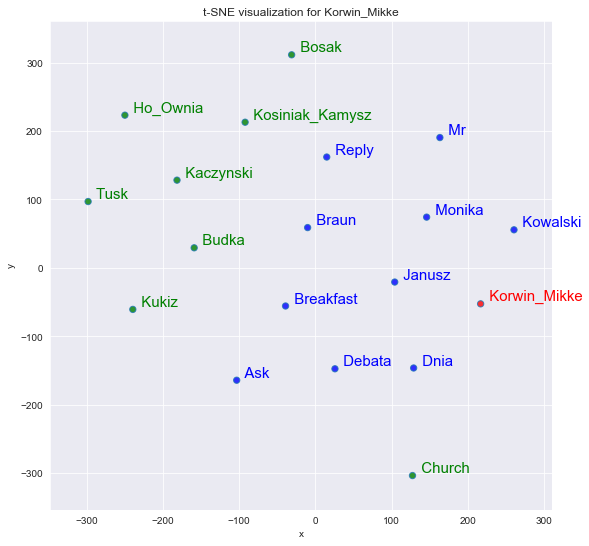

In [155]:
tsnescatterplot(w2v_model, 'korwin_mikke', ['tusk', 'kaczynski', 'budka', 'ho_ownia', 'kukiz', 'kosiniak_kamysz','bosak','church'])

In [22]:
import nltk

In [23]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...


True

In [24]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [25]:
sid=SentimentIntensityAnalyzerntimentIntensityAnalyzer()

In [177]:
sid.polarity_scores(df_clean.iloc[0,0])

{'neg': 0.0, 'neu': 0.938, 'pos': 0.062, 'compound': 0.1531}

In [45]:
def sent(x):
    return sid.polarity_scores(x.iloc[0])

In [171]:
df_clean = df.dropna().drop_duplicates()

In [172]:
df_clean['sent']=df_clean.apply(lambda x: sent(x),axis=1)

In [173]:
df_clean['neg'] = df_clean['sent'].apply(lambda x: x.get('neg'))
df_clean['pos'] = df_clean['sent'].apply(lambda x: x.get('pos'))
df_clean['compound'] = df_clean['sent'].apply(lambda x: x.get('compound'))

In [181]:
df_clean.head()

,0,sent,neg,pos,compound,clean
0,Thread\n- This is not a right-left division. T...,"{'neg': 0.0, 'neu': 0.938, 'pos': 0.062, 'comp...",0.000,0.062,0.1531,Thread\n- This is not a right-left division. T...
1,the head of government announced a veto on th...,"{'neg': 0.072, 'neu': 0.928, 'pos': 0.0, 'comp...",0.072,0.000,-0.2716,the head of government announced a veto on th...
2,difficult year and it will be possible to lea...,"{'neg': 0.169, 'neu': 0.731, 'pos': 0.1, 'comp...",0.169,0.100,-0.1280,difficult year and it will be possible to lea...
3,if we pursue a policy solely in the interests...,"{'neg': 0.0, 'neu': 0.846, 'pos': 0.154, 'comp...",0.000,0.154,0.2500,if we pursue a policy solely in the interests...
4,the Polish nation,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,0.0000,the Polish nation


In [180]:
df_clean['clean']=df_clean[0]

In [202]:
def tusk(x):
    if ' tusk ' in x.lower():
        return 1
    else:
        return 0
    
def kaczynski(x):
    if ' kaczynski ' in x.lower() or ' kaczy_ski ' in x.lower():
        return 1
    else:
        return 0
    
def pis(x):
    if ' law_justice ' in x.lower() or ' pis ' in x.lower():
        return 1
    else:
        return 0
    
def po(x):
    if ' civic_platform ' in x.lower() or ' po ' in x.lower():
        return 1
    else:
        return 0
    
def confederation(x):
    if ' confederation ' in x.lower():
        return 1
    else:
        return 0
    
def korwin(x):
    if ' korwin_mikke ' in x.lower():
        return 1
    else:
        return 0
    
    

In [203]:
df_clean['tusk'] = df_clean['clean'].apply(lambda x: tusk(x))

In [204]:
df_clean['tusk_emo']=df_clean['tusk']*df_clean['compound']

In [205]:
df_clean['kaczynski'] = df_clean['clean'].apply(lambda x: kaczynski(x))
df_clean['kaczynski_emo']=df_clean['kaczynski']*df_clean['compound']

In [206]:
df_clean['pis'] = df_clean['clean'].apply(lambda x: pis(x))
df_clean['pis_emo']=df_clean['pis']*df_clean['compound']

In [207]:
df_clean['po'] = df_clean['clean'].apply(lambda x: po(x))
df_clean['po_emo']=df_clean['po']*df_clean['compound']

In [208]:
df_clean['confederation'] = df_clean['clean'].apply(lambda x: confederation(x))
df_clean['confederation_emo']=df_clean['confederation']*df_clean['compound']

In [209]:
df_clean['korwin'] = df_clean['clean'].apply(lambda x: korwin(x))
df_clean['korwin_emo']=df_clean['korwin']*df_clean['compound']

In [210]:
print(df_clean['kaczynski_emo'].sum())
print(df_clean['tusk_emo'].sum())
print(df_clean['pis_emo'].sum())
print(df_clean['po_emo'].sum())
print(df_clean['confederation_emo'].sum())
print(df_clean['korwin'].sum())

-0.2148
-3.4827
-22.023899999999998
-51.6067
15.059899999999999
0


In [197]:
df_clean[df_clean['tusk']==1]

,0,sent,neg,pos,compound,clean,tusk,tusk_emo,kaczynski,kaczynski_emo,pis,pis_emo,po,po_emo,confederation,confederation_emo,korwin,korwin_emo
533,the newspaper reported.\n\nSEE: Szumowski on ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,0.0000,the newspaper reported.\n\nSEE: Szumowski on ...,1,0.0000,0,0.0,0,0.0,1,0.0000,0,0.0,0,0.0
1281,ProteGO Safe starts to monitor the environmen...,"{'neg': 0.0, 'neu': 0.954, 'pos': 0.046, 'comp...",0.000,0.046,0.4404,ProteGO Safe starts to monitor the environmen...,1,0.4404,0,0.0,0,0.0,0,0.0000,0,0.0,0,0.0
3784,he met with ministers Your browser does not s...,"{'neg': 0.172, 'neu': 0.828, 'pos': 0.0, 'comp...",0.172,0.000,-0.8384,he met with ministers Your browser does not s...,1,-0.8384,0,-0.0,0,-0.0,1,-0.8384,0,-0.0,0,-0.0
4836,he would not persuade the staff to protest. -...,"{'neg': 0.052, 'neu': 0.838, 'pos': 0.11, 'com...",0.052,0.110,0.2960,he would not persuade the staff to protest. -...,1,0.2960,0,0.0,0,0.0,0,0.0000,0,0.0,0,0.0
4837,Duda replied: &quot;I think that Donald Tusk ...,"{'neg': 0.116, 'neu': 0.884, 'pos': 0.0, 'comp...",0.116,0.000,-0.3612,Duda replied: &quot;I think that Donald Tusk ...,1,-0.3612,0,-0.0,0,-0.0,0,-0.0000,0,-0.0,0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37141,&quot; former Prime Minister Donald Tusk wrote...,"{'neg': 0.102, 'neu': 0.813, 'pos': 0.085, 'co...",0.102,0.085,-0.1027,&quot; former Prime Minister Donald Tusk wrote...,1,-0.1027,0,-0.0,0,-0.0,1,-0.1027,0,-0.0,0,-0.0
37149,Donald Tusk.\n\nMorawiecki announces a veto a...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,0.0000,Donald Tusk.\n\nMorawiecki announces a veto a...,1,0.0000,0,0.0,0,0.0,0,0.0000,0,0.0,0,0.0
37150,of which Poland is the greatest beneficiary. ...,"{'neg': 0.0, 'neu': 0.687, 'pos': 0.313, 'comp...",0.000,0.313,0.8074,of which Poland is the greatest beneficiary. ...,1,0.8074,0,0.0,0,0.0,1,0.8074,0,0.0,0,0.0
37902,the European Commission supports the agreemen...,"{'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'comp...",0.000,0.149,0.7845,the European Commission supports the agreemen...,1,0.7845,0,0.0,0,0.0,1,0.7845,0,0.0,0,0.0


In [201]:
df_clean.loc[4837,0]

' Duda replied: &quot;I think that Donald Tusk has been fighting for Rafał Trzaskowski to become president from the very beginning'